/home/yuntian/anaconda3/envs/linux_QNM_env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


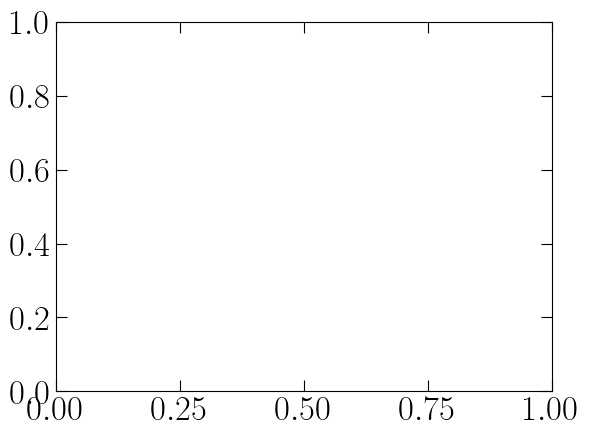

In [1]:
# 我们来试图生产更多的图片
import numpy as np
import scipy
from scipy import stats
import My_Fitting
import qnm
from kuibit import simdir as sd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import pickle
from adjustText import adjust_text

plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8
plt.rcParams["xtick.minor.size"] = 4
plt.rcParams["ytick.minor.size"] = 4
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["axes.labelpad"] = 8
plt.rcParams["figure.constrained_layout.h_pad"] = 0
plt.rcParams["text.usetex"] = True
plt.rcParams["font.sans-serif"] = ["Times New Roman"]
plt.rcParams["mathtext.fontset"] = "stix"
plt.tick_params(axis="both", which="minor", labelsize=18)

In [3]:
# 我们来画下mode强度与220模式比值的图
# 我们先使用jaxqualin
from jaxqualin.data import (download_hyperfit_data, 
                            download_interpolate_data,
                            make_hyper_fit_functions,
                            make_interpolators)

hyperfit_functions = make_hyper_fit_functions()
hyper_interpolators = make_interpolators()

In [16]:
q=36/29
eta, chi_p, chi_m = q/(1+q)**2,0,0

A220_fit=hyperfit_functions["2.2.0"]['A'](eta, chi_p, chi_m)
A330_fit=hyperfit_functions["3.3.0"]['A'](eta, chi_p, chi_m)
A440_fit=hyperfit_functions["4.4.0"]['A'](eta, chi_p, chi_m)
A550_fit=hyperfit_functions["5.5.0"]['A'](eta, chi_p, chi_m)

print(A220_fit,A330_fit,A440_fit,A550_fit)

0.969435099564632 0.05386996106730708 0.035960165549969246 0.009051235402055225


In [42]:
# 难绷，我们之前的数据怎么好像是现算的呀，也合理。。。因为N算是手调的
# 不对，拟合的话还是存下来了，就是用起来有点复杂。。。
# 之前好像倒是没怎么调N_free，但是手选了一下最稳定时间因为有些看着明显不对

dA=10.0
lambda_list=[0,0.01,0.05,0.1,0.2,0.3]
name_list=[["0","1","5","10","20","30"],["0","s1","s5","s10","s20","s30"],["0","o1","o5","o10","o20","o30"]]

C_r_220_list=np.zeros([3,len(lambda_list)])
C_i_220_list=np.zeros([3,len(lambda_list)])
sigma_220_list=np.zeros([3,len(lambda_list)])
C_r_221_list=np.zeros([3,len(lambda_list)])
C_i_221_list=np.zeros([3,len(lambda_list)])
sigma_221_list=np.zeros([3,len(lambda_list)])

Crh_r_220_list=np.zeros([3,len(lambda_list)])
Crh_i_220_list=np.zeros([3,len(lambda_list)])
Crh_r_221_list=np.zeros([3,len(lambda_list)])
Crh_i_221_list=np.zeros([3,len(lambda_list)])
sigma_rh_220_list=np.zeros([3,len(lambda_list)])
sigma_rh_221_list=np.zeros([3,len(lambda_list)])

for i_name in range(len(lambda_list)):
    for i_family in range(3):
        data=np.genfromtxt("Figure_data/strain_"+name_list[i_family][i_name]+"_22_cutoff_low_0.005.dat")
        h_p=data[:,1]
        h_c=data[:,2]
        h_abs=(h_p**2+h_c**2)**(1/2)
        index_peak=np.argmax(h_abs)


        data=np.genfromtxt("Figure_data/Weyl4_mode_"+name_list[i_family][i_name]+"_22.dat")
        t=data[:,0]
        psi4_r=data[:,1]
        psi4_i=data[:,2]
        index_50=np.argmin(np.abs(t-t[index_peak]-50))+1
        index_100=np.argmin(np.abs(t-t[index_peak]-100))+1

        t_arr=np.zeros(index_100-index_peak)
        psi4_r_arr=np.zeros(index_100-index_peak)
        psi4_i_arr=np.zeros(index_100-index_peak)
        t0_arr=np.zeros(index_50-index_peak)
        N_free=3
        N_fix=2

        for i in range(index_100-index_peak):
            t_arr[i]=t[index_peak+i]-t[index_peak]
            psi4_r_arr[i]=psi4_r[index_peak+i]
            psi4_i_arr[i]=psi4_i[index_peak+i]
        
        for i in range(index_50-index_peak):
            t0_arr[i]=t[index_peak+i]-t[index_peak]

        with open("Figure_data/"+name_list[i_family][i_name]+"_"+"A_phi_22.pkl",'rb') as file:
            params_fit=pickle.load(file)
        C_r_220=np.zeros(len(t0_arr))
        C_i_220=np.zeros(len(t0_arr))
        C_r_221=np.zeros(len(t0_arr))
        C_i_221=np.zeros(len(t0_arr))
        for i in range(len(t0_arr)):
            C_r_220[i]=params_fit[i][0]*np.cos(params_fit[i][1])
            C_i_220[i]=-params_fit[i][0]*np.sin(params_fit[i][1])
            C_r_221[i]=params_fit[i][2]*np.cos(params_fit[i][3])
            C_i_221[i]=-params_fit[i][2]*np.sin(params_fit[i][3])

        with sd.SimDir("/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name_list[i_family][i_name],\
                        pickle_file="/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name_list[i_family][i_name]+".pickle") as sim:
            pass

        timeseries=sim.ts
        m1=timeseries.scalar["qlm_mass[0]"]
        m2=timeseries.scalar["qlm_mass[1]"]
        mt=timeseries.scalar["qlm_mass[2]"]
        s1=timeseries.scalar["qlm_spin[0]"]
        s2=timeseries.scalar["qlm_spin[1]"]
        st=timeseries.scalar["qlm_spin[2]"]
        q1=timeseries.scalar["qlm_charge[0]"]
        q2=timeseries.scalar["qlm_charge[1]"]
        qt=timeseries.scalar["qlm_charge[2]"]

        M=1
        M_f=mt(t[index_100])
        a_f=st(t[index_100])/M_f**2
        q_f=qt(t[index_100])/M_f

        omega_GR_220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=a_f)[0]/M_f*M

        dt=-np.log(dA)/omega_GR_220.imag
        # 首先找到离 50 （t0_arr结尾）最近的dt
        index_end=np.argmin(np.abs(t0_arr-(t0_arr[-1]-dt)))
        n_sta=index_end+1
        sta_list=np.zeros(n_sta)
        for i in range(n_sta):
            index_dt=np.argmin(np.abs(t0_arr-(t0_arr[i]+dt)))+1
            sta_list[i]=My_Fitting.sta_cal_A(C_r_220[i:index_dt],C_i_220[i:index_dt])

        index_min=np.argmin(sta_list)
        index_min_dt=np.argmin(np.abs(t0_arr-(t0_arr[index_min]+dt)))+1

        C_r_220_list[i_family][i_name]=np.average(C_r_220[index_min:index_min_dt])
        C_i_220_list[i_family][i_name]=np.average(C_i_220[index_min:index_min_dt])
        sigma_220_list[i_family][i_name]=sta_list[index_min]

        omega_GR_221=qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=a_f)[0]/M_f*M

        dt=-np.log(dA)/omega_GR_221.imag
        # 首先找到离 50 （t0_arr结尾）最近的dt
        index_end=np.argmin(np.abs(t0_arr-(t0_arr[-1]-dt)))
        n_sta=index_end+1
        sta_list=np.zeros(n_sta)
        for i in range(n_sta):
            index_dt=np.argmin(np.abs(t0_arr-(t0_arr[i]+dt)))+1
            sta_list[i]=My_Fitting.sta_cal_A(C_r_221[i:index_dt],C_i_221[i:index_dt])

        index_min=np.argmin(sta_list)

        # 有一些需要特别处理
        if((i_name==0) or (i_family==1 and (i_name==1 or i_name==2)) or (i_family==2 and (i_name==2 or i_name==4))):
            index_min=np.argmin(sta_list[0:40])


        index_min_dt=np.argmin(np.abs(t0_arr-(t0_arr[index_min]+dt)))+1
        print(name_list[i_family][i_name],t0_arr[index_min])

        C_r_221_list[i_family][i_name]=np.average(C_r_221[index_min:index_min_dt])
        C_i_221_list[i_family][i_name]=np.average(C_i_221[index_min:index_min_dt])
        sigma_221_list[i_family][i_name]=sta_list[index_min]

        num=0
        den=0
        for k in range(4):
            for j in range(4):
                num+=My_Fitting.bkj_220r[k][j]*a_f**k*q_f**j
                den+=My_Fitting.ckj_220r[k][j]*a_f**k*q_f**j

        omega_KN_220_r=(qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=0)[0].real*num/den)/M_f*M

        num=0
        den=0
        for k in range(4):
            for j in range(4):
                num+=My_Fitting.bkj_220i[k][j]*a_f**k*q_f**j
                den+=My_Fitting.ckj_220i[k][j]*a_f**k*q_f**j

        omega_KN_220_i=(qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=0)[0].imag*num/den)/M_f*M

        num=0
        den=0
        for k in range(4):
            for j in range(4):
                num+=My_Fitting.bkj_221r[k][j]*a_f**k*q_f**j
                den+=My_Fitting.ckj_221r[k][j]*a_f**k*q_f**j

        omega_KN_221_r=(qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=0)[0].real*num/den)/M_f*M

        num=0
        den=0
        for k in range(4):
            for j in range(4):
                num+=My_Fitting.bkj_221i[k][j]*a_f**k*q_f**j
                den+=My_Fitting.ckj_221i[k][j]*a_f**k*q_f**j

        omega_KN_221_i=(qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=0)[0].imag*num/den)/M_f*M

        # 原理上我们上面算了M omega所以为了补量纲下面是*M
        Crh_r_220_list[i_family][i_name]=(-(C_r_220_list[i_family][i_name]+1.0j*C_i_220_list[i_family][i_name])/(omega_KN_220_r+1.0j*omega_KN_220_i)**2).real*110.69*M
        Crh_i_220_list[i_family][i_name]=(-(C_r_220_list[i_family][i_name]+1.0j*C_i_220_list[i_family][i_name])/(omega_KN_220_r+1.0j*omega_KN_220_i)**2).imag*110.69*M
        Crh_r_221_list[i_family][i_name]=(-(C_r_221_list[i_family][i_name]+1.0j*C_i_221_list[i_family][i_name])/(omega_KN_221_r+1.0j*omega_KN_221_i)**2).real*110.69*M
        Crh_i_221_list[i_family][i_name]=(-(C_r_221_list[i_family][i_name]+1.0j*C_i_221_list[i_family][i_name])/(omega_KN_221_r+1.0j*omega_KN_221_i)**2).imag*110.69*M
        sigma_rh_220_list[i_family][i_name]=sigma_220_list[i_family][i_name]/np.abs(omega_KN_220_r+1.0j*omega_KN_220_i)**2
        sigma_rh_221_list[i_family][i_name]=sigma_221_list[i_family][i_name]/np.abs(omega_KN_221_r+1.0j*omega_KN_221_i)**2

0 17.59999999999991
0 17.59999999999991
0 17.59999999999991
1 12.0
s1 17.59999999999991
o1 19.200000000000045
5 8.0
s5 18.399999999999864
o5 16.800000000000182
10 16.799999999999955
s10 0.0
o10 20.799999999999955
20 16.799999999999727
s20 14.400000000000091
o20 14.399999999999864
30 4.0
s30 18.40000000000009
o30 17.600000000000136


In [64]:
# 这是220对++的值，我们只需要首尾
print((Crh_r_220_list[0]**2+Crh_i_220_list[0]**2)**(1/2))

print((Crh_r_220_list[1]**2+Crh_i_220_list[1]**2)**(1/2))

print((Crh_r_220_list[2]**2+Crh_i_220_list[2]**2)**(1/2))

[1.01296393 0.98427988 1.00101609 0.98410576 0.94752511 0.94875514]
[1.01296393 1.00918644 0.99402847 1.00301893 1.00630636 1.01990887]
[1.01296393 1.03244791 0.97464898 1.00576698 1.03332664 1.02910852]


In [68]:
dA=10.0
lambda_list=[0,0.01,0.05,0.1,0.2,0.3]
name_list=[["0","1","5","10","20","30"],["0","s1","s5","s10","s20","s30"],["0","o1","o5","o10","o20","o30"]]

C_r_330_list=np.zeros([3,len(lambda_list)])
C_i_330_list=np.zeros([3,len(lambda_list)])
sigma_330_list=np.zeros([3,len(lambda_list)])

Crh_r_330_list=np.zeros([3,len(lambda_list)])
Crh_i_330_list=np.zeros([3,len(lambda_list)])
sigma_rh_330_list=np.zeros([3,len(lambda_list)])

for i_name in range(len(lambda_list)):
    for i_family in range(3):
        data=np.genfromtxt("Figure_data/strain_"+name_list[i_family][i_name]+"_22_cutoff_low_0.005.dat")
        h_p=data[:,1]
        h_c=data[:,2]
        h_abs=(h_p**2+h_c**2)**(1/2)
        index_peak=np.argmax(h_abs)
        t=data[:,0]
        index_50=np.argmin(np.abs(t-t[index_peak]-50))+1
        index_100=np.argmin(np.abs(t-t[index_peak]-100))+1

        t_arr=np.zeros(index_100-index_peak)
        t0_arr=np.zeros(index_50-index_peak)
        N_free=4
        N_fix=1

        for i in range(index_100-index_peak):
            t_arr[i]=t[index_peak+i]-t[index_peak]
        
        for i in range(index_50-index_peak):
            t0_arr[i]=t[index_peak+i]-t[index_peak]

        with open("Figure_data/"+name_list[i_family][i_name]+"_"+"A_phi_33_Nf6.pkl",'rb') as file:
            params_fit=pickle.load(file)
        C_r_330=np.zeros(len(t0_arr))
        C_i_330=np.zeros(len(t0_arr))
        for i in range(len(t0_arr)):
            C_r_330[i]=params_fit[i][0]*np.cos(params_fit[i][1])
            C_i_330[i]=-params_fit[i][0]*np.sin(params_fit[i][1])

        with sd.SimDir("/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name_list[i_family][i_name],\
                        pickle_file="/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name_list[i_family][i_name]+".pickle") as sim:
            pass

        timeseries=sim.ts
        m1=timeseries.scalar["qlm_mass[0]"]
        m2=timeseries.scalar["qlm_mass[1]"]
        mt=timeseries.scalar["qlm_mass[2]"]
        s1=timeseries.scalar["qlm_spin[0]"]
        s2=timeseries.scalar["qlm_spin[1]"]
        st=timeseries.scalar["qlm_spin[2]"]
        q1=timeseries.scalar["qlm_charge[0]"]
        q2=timeseries.scalar["qlm_charge[1]"]
        qt=timeseries.scalar["qlm_charge[2]"]

        M=1
        M_f=mt(t[index_100])
        a_f=st(t[index_100])/M_f**2
        q_f=qt(t[index_100])/M_f

        omega_GR_330=qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=a_f)[0]/M_f*M

        dt=-np.log(dA)/omega_GR_330.imag
        # 首先找到离 50 （t0_arr结尾）最近的dt
        index_end=np.argmin(np.abs(t0_arr-(t0_arr[-1]-dt)))
        n_sta=index_end+1
        sta_list=np.zeros(n_sta)
        for i in range(n_sta):
            index_dt=np.argmin(np.abs(t0_arr-(t0_arr[i]+dt)))+1
            sta_list[i]=My_Fitting.sta_cal_A(C_r_330[i:index_dt],C_i_330[i:index_dt])

        index_min=np.argmin(sta_list)
        index_min_dt=np.argmin(np.abs(t0_arr-(t0_arr[index_min]+dt)))+1

        C_r_330_list[i_family][i_name]=np.average(C_r_330[index_min:index_min_dt])
        C_i_330_list[i_family][i_name]=np.average(C_i_330[index_min:index_min_dt])
        sigma_330_list[i_family][i_name]=sta_list[index_min]

        num=0
        den=0
        for k in range(4):
            for j in range(4):
                num+=My_Fitting.bkj_330r[k][j]*a_f**k*q_f**j
                den+=My_Fitting.ckj_330r[k][j]*a_f**k*q_f**j

        omega_KN_330_r=(qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=0)[0].real*num/den)/M_f*M

        num=0
        den=0
        for k in range(4):
            for j in range(4):
                num+=My_Fitting.bkj_330i[k][j]*a_f**k*q_f**j
                den+=My_Fitting.ckj_330i[k][j]*a_f**k*q_f**j

        omega_KN_330_i=(qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=0)[0].imag*num/den)/M_f*M

        # 原理上我们上面算了M omega所以为了补量纲下面是*M
        Crh_r_330_list[i_family][i_name]=(-(C_r_330_list[i_family][i_name]+1.0j*C_i_330_list[i_family][i_name])/(omega_KN_330_r+1.0j*omega_KN_330_i)**2).real*110.69*M
        Crh_i_330_list[i_family][i_name]=(-(C_r_330_list[i_family][i_name]+1.0j*C_i_330_list[i_family][i_name])/(omega_KN_330_r+1.0j*omega_KN_330_i)**2).imag*110.69*M
        sigma_rh_330_list[i_family][i_name]=sigma_330_list[i_family][i_name]/np.abs(omega_KN_330_r+1.0j*omega_KN_330_i)**2

In [71]:
print((Crh_r_330_list[0]**2+Crh_i_330_list[0]**2)**(1/2))

print((Crh_r_330_list[1]**2+Crh_i_330_list[1]**2)**(1/2))

print((Crh_r_330_list[2]**2+Crh_i_330_list[2]**2)**(1/2))

[0.06815149 0.06677584 0.06991413 0.06410789 0.06224627 0.06189463]
[0.06815149 0.06848355 0.06577921 0.06503292 0.07001586 0.06656873]
[0.06815149 0.06879894 0.07049712 0.06401038 0.07023308 0.06752831]


In [4]:
# 然后比较麻烦的是我们要新处理44,55模式
# 基本上要新写拟合和挑选的部分
# 先把拟合跑了，在另一个文件里我们已经跑了44，再跑下55

# 趁机来写一下提取的程序吧，应该是仿照上面的程序，不过这次也不需要估计误差

dA=10.0
lambda_list=[0,0.01,0.05,0.1,0.2,0.3]
name_list=[["0","1","5","10","20","30"],["0","s1","s5","s10","s20","s30"],["0","o1","o5","o10","o20","o30"]]

C_r_440_list=np.zeros([3,len(lambda_list)])
C_i_440_list=np.zeros([3,len(lambda_list)])
sigma_440_list=np.zeros([3,len(lambda_list)])

# 这个误差就大了，我们得用拟合的omega来反算啊。。。
Crh_r_440_list=np.zeros([3,len(lambda_list)])
Crh_i_440_list=np.zeros([3,len(lambda_list)])
sigma_rh_440_list=np.zeros([3,len(lambda_list)])

# 所以还要记下拟合的omega
omega_r_440_list=np.zeros([3,len(lambda_list)])
omega_i_440_list=np.zeros([3,len(lambda_list)])

for i_name in range(len(lambda_list)):
    for i_family in range(3):
        data=np.genfromtxt("Figure_data/strain_"+name_list[i_family][i_name]+"_22_cutoff_low_0.005.dat")
        h_p=data[:,1]
        h_c=data[:,2]
        h_abs=(h_p**2+h_c**2)**(1/2)
        index_peak=np.argmax(h_abs)
        t=data[:,0]
        index_50=np.argmin(np.abs(t-t[index_peak]-50))+1
        index_100=np.argmin(np.abs(t-t[index_peak]-100))+1

        t_arr=np.zeros(index_100-index_peak)
        t0_arr=np.zeros(index_50-index_peak)
        N_free=5
        N_fix=0

        for i in range(index_100-index_peak):
            t_arr[i]=t[index_peak+i]-t[index_peak]
        
        for i in range(index_50-index_peak):
            t0_arr[i]=t[index_peak+i]-t[index_peak]

        with sd.SimDir("/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name_list[i_family][i_name],\
            pickle_file="/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name_list[i_family][i_name]+".pickle") as sim:
            pass

        timeseries=sim.ts
        m1=timeseries.scalar["qlm_mass[0]"]
        m2=timeseries.scalar["qlm_mass[1]"]
        mt=timeseries.scalar["qlm_mass[2]"]
        s1=timeseries.scalar["qlm_spin[0]"]
        s2=timeseries.scalar["qlm_spin[1]"]
        st=timeseries.scalar["qlm_spin[2]"]
        q1=timeseries.scalar["qlm_charge[0]"]
        q2=timeseries.scalar["qlm_charge[1]"]
        qt=timeseries.scalar["qlm_charge[2]"]

        M=1
        M_f=mt(t[index_100])
        a_f=st(t[index_100])/M_f**2
        q_f=qt(t[index_100])/M_f

        omega_GR_440=qnm.modes_cache(s=-2,l=4,m=4,n=0)(a=a_f)[0]/M_f*M

        with open("Figure_data/"+name_list[i_family][i_name]+"_"+"A_phi_44.pkl",'rb') as file:
            params_fit=pickle.load(file)
        # 这里是第一个重要的不一样
        # 我们得先确定哪一个是我们想要的模式
        # 我们用20%圆形区间来找吧
        flag_in=np.zeros(N_free)
        for i_N in range(N_free):
            for i_f in range(len(t0_arr)):
                omega_fit_r=params_fit[i_f][4*i_N+2]
                omega_fit_i=params_fit[i_f][4*i_N+3]
                if((omega_fit_r-omega_GR_440.real)**2+(omega_fit_i-omega_GR_440.imag)**2<(np.abs(omega_GR_440)*0.2)**2):
                    flag_in[i_N]+=1
        # 然后最大的那个就是我们想要的(我们不考虑模式交换)

        C_r_440=np.zeros(len(t0_arr))
        C_i_440=np.zeros(len(t0_arr))
        omega_r_440=np.zeros(len(t0_arr))
        omega_i_440=np.zeros(len(t0_arr))
        for i in range(len(t0_arr)):
            C_r_440[i]=params_fit[i][4*np.argmax(flag_in)+0]*np.cos(params_fit[i][4*np.argmax(flag_in)+1])
            C_i_440[i]=-params_fit[i][4*np.argmax(flag_in)+0]*np.sin(params_fit[i][4*np.argmax(flag_in)+1])
            omega_r_440[i]=params_fit[i][4*np.argmax(flag_in)+2]
            omega_i_440[i]=params_fit[i][4*np.argmax(flag_in)+3]


        dt=-np.log(dA)/omega_GR_440.imag
        # 首先找到离 50 （t0_arr结尾）最近的dt
        index_end=np.argmin(np.abs(t0_arr-(t0_arr[-1]-dt)))
        n_sta=index_end+1
        sta_list=np.zeros(n_sta)
        for i in range(n_sta):
            index_dt=np.argmin(np.abs(t0_arr-(t0_arr[i]+dt)))+1
            sta_list[i]=My_Fitting.sta_cal_ful(C_r_440[i:index_dt],C_i_440[i:index_dt],omega_r_440[i:index_dt],omega_i_440[i:index_dt])

        index_min=np.argmin(sta_list)
        index_min_dt=np.argmin(np.abs(t0_arr-(t0_arr[index_min]+dt)))+1

        C_r_440_list[i_family][i_name]=np.average(C_r_440[index_min:index_min_dt])
        C_i_440_list[i_family][i_name]=np.average(C_i_440[index_min:index_min_dt])
        omega_r_440_list[i_family][i_name]=np.average(omega_r_440[index_min:index_min_dt])
        omega_i_440_list[i_family][i_name]=np.average(omega_i_440[index_min:index_min_dt])
        sigma_440_list[i_family][i_name]=sta_list[index_min]

        # 原理上我们上面算了M omega所以为了补量纲下面是*M
        Crh_r_440_list[i_family][i_name]=(-(C_r_440_list[i_family][i_name]+1.0j*C_i_440_list[i_family][i_name])/(omega_r_440_list[i_family][i_name]+1.0j*omega_i_440_list[i_family][i_name])**2).real*110.69*M
        Crh_i_440_list[i_family][i_name]=(-(C_r_440_list[i_family][i_name]+1.0j*C_i_440_list[i_family][i_name])/(omega_r_440_list[i_family][i_name]+1.0j*omega_i_440_list[i_family][i_name])**2).imag*110.69*M
        sigma_rh_440_list[i_family][i_name]=sigma_440_list[i_family][i_name]/np.abs(omega_r_440_list[i_family][i_name]+1.0j*omega_i_440_list[i_family][i_name])**2
        

Text(0, 0.5, '$M\\omega_{i}$')

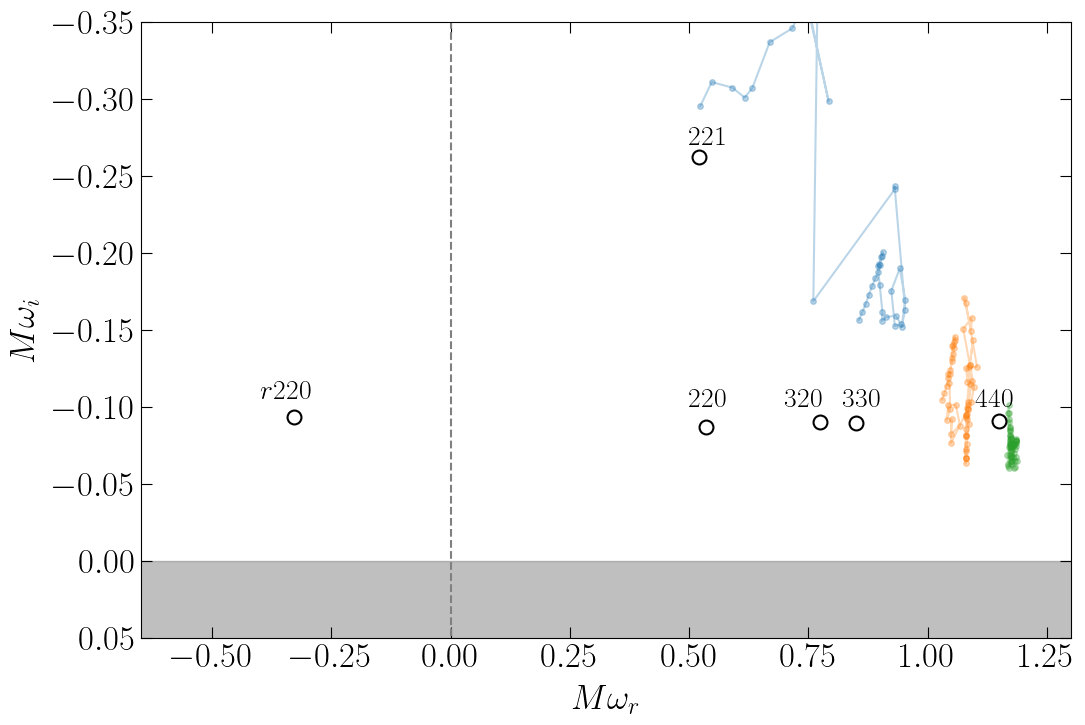

In [20]:
# 我们不能鲁莽的使用我们的值，最好还是画些图看看到底怎么个事
# 从画拟合的图看看有没有在440模式边上开始吧
# 质量什么就差不多得了感觉。。

with open("Figure_data/"+"30"+"_"+"A_phi_44_N3.pkl",'rb') as file:
    params_fit=pickle.load(file)

N_free=3
fig, ax = plt.subplots(figsize=(12,8))

# 绘制拟合结果
for k in range(N_free):
    omega_r_fit=np.zeros(len(t0_arr))
    omega_i_fit=np.zeros(len(t0_arr))
    for i in range(len(t0_arr)):
        omega_r_fit[i]=params_fit[i][2*N_fix+4*k+2]
        omega_i_fit[i]=params_fit[i][2*N_fix+4*k+3]

    ax.plot(omega_r_fit,omega_i_fit,alpha=0.3,marker="o",markersize=4)

# omega_list=["c,2,2,0","c,2,2,1","c,2,2,2", # natural linear modes
#             "c,3,2,0","c,4,2,0","c,5,2,0","c,6,2,0","c,7,2,0","c,8,2,0", # mixing modes
#             "constant", # constant mode
#             "r,2,2,0", # retrograde modes
#             ] 

omega_list=["c,2,2,0","r,2,2,0","c,2,2,1","c,3,2,0","c,3,3,0","c,4,4,0"]

def to_latex_format(s):
    return rf'$\rm {s}$'

texts=[]
for i in range(len(omega_list)):
    first_part=omega_list[i].split(',')[0]
    if first_part == "constant":
        omega_x=0
        omega_y=0
    elif first_part == "c":
        parts=omega_list[i].split(',')[1:]
        l,m,n=map(int,parts)
        omega_i=qnm.modes_cache(s=-2,l=l,m=m,n=n)(a=a_f)[0]
        omega_x=omega_i.real*M/M_f
        omega_y=omega_i.imag*M/M_f
    elif first_part == "r":
        parts=omega_list[i].split(',')[1:]
        l,m,n=map(int,parts)
        omega_i=qnm.modes_cache(s=-2,l=l,m=-m,n=n)(a=a_f)[0]
        omega_x=-omega_i.real*M/M_f
        omega_y=omega_i.imag*M/M_f
    else:
        omega_x=-100
        omega_y=-100
        print("invalid mode name")
    ax.plot(omega_x,omega_y,marker='o',markeredgecolor='black',\
    markerfacecolor='none',markersize=10,markeredgewidth=1.5)
#     texts.append(ax.annotate(to_latex_format(omega_list[i]),[omega_x,omega_y],\
#     ha='center',fontsize=20))

# adjust_text(texts,expand_text=(1.4, 2), expand_points=(1.0, 1.2))
ax.text(0.5,-0.1,r"$220$",fontsize=20)
ax.text(0.5,-0.27,r"$221$",fontsize=20)
ax.text(0.7,-0.1,r"$320$",fontsize=20)
ax.text(0.82,-0.1,r"$330$",fontsize=20)
ax.text(1.1,-0.1,r"$440$",fontsize=20)
ax.text(-0.4,-0.105,r"$r220$",fontsize=20)

ax.set_xlim([-0.65,1.3])
ax.set_ylim([-0.35,0.05])
ax.invert_yaxis()

# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax.plot([0,0],[-1,1],'--',color="gray")

x = np.array([-1, 2])
y1 = np.array([1, 1])
ax.fill_between(x, y1, color="gray", alpha=0.5)


plt.xlabel(r"$M\omega_{r}$",fontsize=25)
plt.ylabel(r"$M\omega_{i}$",fontsize=25)

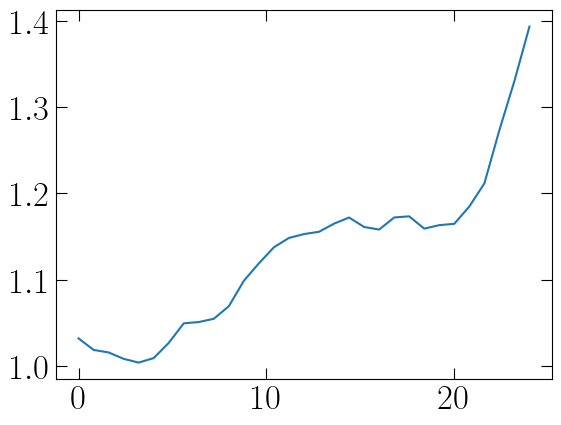

In [21]:
# 然后是我们的振幅看起来都偏小
# 所以还是得看一眼稳定性的图，是不是我们取错位置了？
# 虽然感觉哪怕上面那个看着很稳定的也很小。。。
# 额，这个图需要额外的一些计算。。。。

# 这个图和之前程序无关我们不必要重新跑

#选择
name="30"

data=np.genfromtxt("Figure_data/strain_"+name+"_22_cutoff_low_0.005.dat")
h_p=data[:,1]
h_c=data[:,2]
h_abs=(h_p**2+h_c**2)**(1/2)
index_peak=np.argmax(h_abs)
t=data[:,0]
index_50=np.argmin(np.abs(t-t[index_peak]-50))+1
index_100=np.argmin(np.abs(t-t[index_peak]-100))+1

t_arr=np.zeros(index_100-index_peak)
t0_arr=np.zeros(index_50-index_peak)
N_free=3
N_fix=0

for i in range(index_100-index_peak):
    t_arr[i]=t[index_peak+i]-t[index_peak]
        
for i in range(index_50-index_peak):
    t0_arr[i]=t[index_peak+i]-t[index_peak]

with sd.SimDir("/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name,\
    pickle_file="/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name+".pickle") as sim:
    pass

timeseries=sim.ts
m1=timeseries.scalar["qlm_mass[0]"]
m2=timeseries.scalar["qlm_mass[1]"]
mt=timeseries.scalar["qlm_mass[2]"]
s1=timeseries.scalar["qlm_spin[0]"]
s2=timeseries.scalar["qlm_spin[1]"]
st=timeseries.scalar["qlm_spin[2]"]
q1=timeseries.scalar["qlm_charge[0]"]
q2=timeseries.scalar["qlm_charge[1]"]
qt=timeseries.scalar["qlm_charge[2]"]

M=1
M_f=mt(t[index_100])
a_f=st(t[index_100])/M_f**2
q_f=qt(t[index_100])/M_f

omega_GR_440=qnm.modes_cache(s=-2,l=4,m=4,n=0)(a=a_f)[0]/M_f*M

with open("Figure_data/"+name+"_"+"A_phi_44_N3.pkl",'rb') as file:
    params_fit=pickle.load(file)

flag_in=np.zeros(N_free)
for i_N in range(N_free):
    for i_f in range(len(t0_arr)):
        omega_fit_r=params_fit[i_f][4*i_N+2]
        omega_fit_i=params_fit[i_f][4*i_N+3]
        if((omega_fit_r-omega_GR_440.real)**2+(omega_fit_i-omega_GR_440.imag)**2<(np.abs(omega_GR_440)*0.2)**2):
            flag_in[i_N]+=1

C_r_440=np.zeros(len(t0_arr))
C_i_440=np.zeros(len(t0_arr))
omega_r_440=np.zeros(len(t0_arr))
omega_i_440=np.zeros(len(t0_arr))
for i in range(len(t0_arr)):
    C_r_440[i]=params_fit[i][4*np.argmax(flag_in)+0]*np.cos(params_fit[i][4*np.argmax(flag_in)+1])
    C_i_440[i]=-params_fit[i][4*np.argmax(flag_in)+0]*np.sin(params_fit[i][4*np.argmax(flag_in)+1])
    omega_r_440[i]=params_fit[i][4*np.argmax(flag_in)+2]
    omega_i_440[i]=params_fit[i][4*np.argmax(flag_in)+3]

dt=-np.log(10.0)/omega_GR_440.imag
# 首先找到离 50 （t0_arr结尾）最近的dt
index_end=np.argmin(np.abs(t0_arr-(t0_arr[-1]-dt)))
n_sta=index_end+1
sta_list=np.zeros(n_sta)

for i in range(n_sta):
    index_dt=np.argmin(np.abs(t0_arr-(t0_arr[i]+dt)))+1
    sta_list[i]=My_Fitting.sta_cal_ful(C_r_440[i:index_dt],C_i_440[i:index_dt],omega_r_440[i:index_dt],omega_i_440[i:index_dt])

plt.plot(t0_arr[0:n_sta],sta_list)

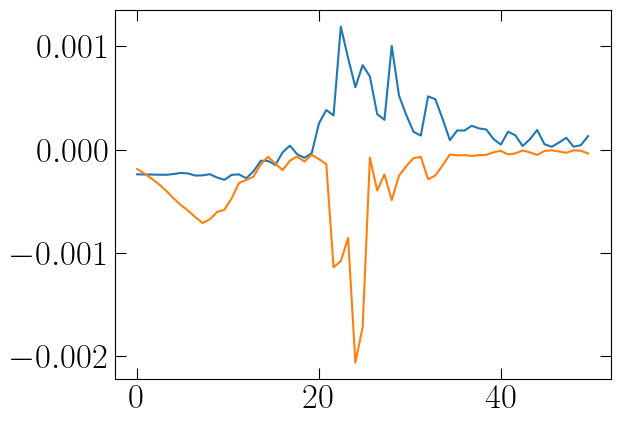

In [22]:
plt.plot(t0_arr,C_r_440)
plt.plot(t0_arr,C_i_440)

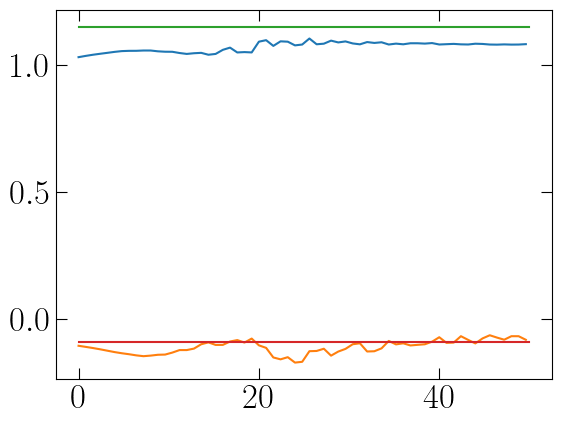

In [23]:
plt.plot(t0_arr,omega_r_440)
plt.plot(t0_arr,omega_i_440)
plt.plot([0,50],[omega_GR_440.real,omega_GR_440.real])
plt.plot([0,50],[omega_GR_440.imag,omega_GR_440.imag])

In [11]:
print((Crh_r_440_list[0]**2+Crh_i_440_list[0]**2)**(1/2))
print((Crh_r_440_list[1]**2+Crh_i_440_list[1]**2)**(1/2))
print((Crh_r_440_list[2]**2+Crh_i_440_list[2]**2)**(1/2))

[0.0228237  0.01051529 0.01035476 0.00202682 0.01143624 0.03005368]
[0.0228237  0.01271062 0.02626671 0.08475383 0.01344658 0.01185444]
[0.0228237  0.01122772 0.03435096 0.07311261 0.01323766 0.01229557]


(0.5, 4.5)

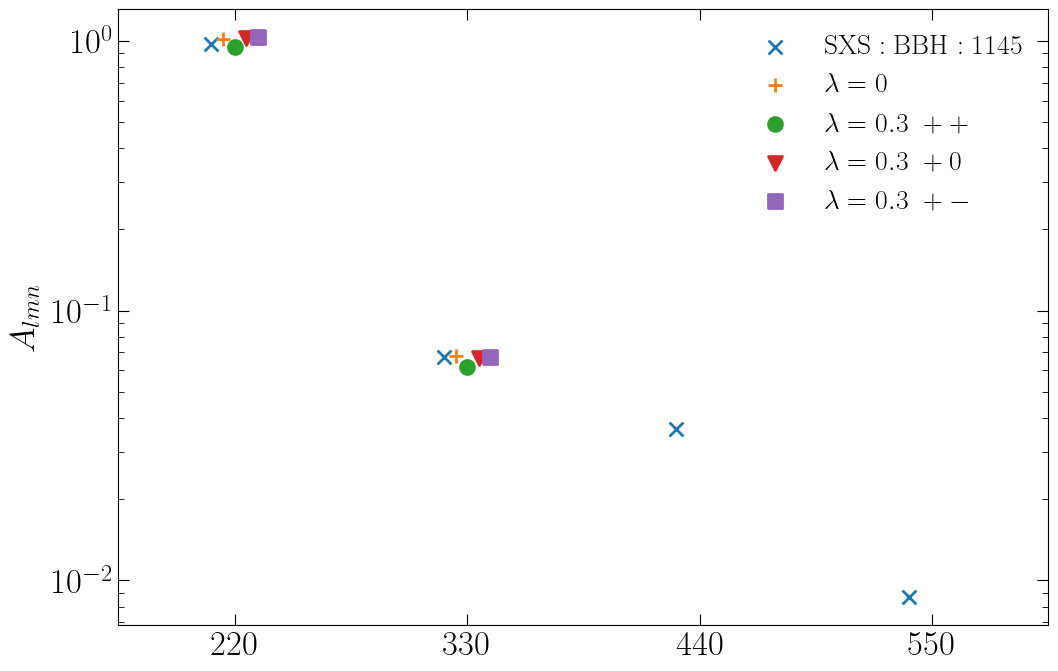

In [72]:
plt.figure(figsize=(12,8))

# 这当成一个GR基准值
plt.scatter([1-0.1,2-0.1,3-0.1,4-0.1], [0.969,0.0673,0.0365,0.00865], marker='x', s=100, linewidths=2,label=r"$\rm SXS:BBH:1145$")

# 我们需要一个我们GR的fit值
plt.scatter([1-0.05,2-0.05],[1.01296393,0.06815149],marker='+', s=100, linewidths=2,label=r"$\lambda=0$")

# ++ 0.3
plt.scatter([1,2],[0.94875514,0.06189463],marker='o', s=100, linewidths=2,label=r"$\lambda=0.3\ ++$")

# +0 0.3
plt.scatter([1+0.05,2+0.05],[1.01990887,0.06656873],marker='v', s=100, linewidths=2,label=r"$\lambda=0.3\ +0$")

# +- 0.3
plt.scatter([1+0.1,2+0.1],[1.02910852,0.06752831],marker='s', s=100, linewidths=2,label=r"$\lambda=0.3\ +-$")

plt.yscale("log")
plt.xticks([1,2,3,4],labels=[r"$220$",r"$330$",r"$440$",r"$550$"])
plt.legend(fontsize=20,frameon=False)
plt.ylabel(r"$A_{lmn}$",fontsize=25)
plt.xlim([0.5,4.5])

In [2]:
# 我们想试着画一下higher mode的拟合情况，希望有个好一点的模式
name_list=["30"]
for i_name in range(len(name_list)):
    #用到了index_100这个东西
    data=np.genfromtxt("Figure_data/strain_"+name_list[i_name]+"_22_cutoff_low_0.005.dat")
    h_p=data[:,1]
    h_c=data[:,2]
    h_abs=(h_p**2+h_c**2)**(1/2)
    index_peak=np.argmax(h_abs)
    t=data[:,0]
    index_50=np.argmin(np.abs(t-t[index_peak]-50))+1
    index_100=np.argmin(np.abs(t-t[index_peak]-100))+1

    with sd.SimDir("/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name_list[i_name],\
                    pickle_file="/home/yuntian/vscode_codes/QNM_compare/Kerr_Newman/"+name_list[i_name]+".pickle") as sim:
        pass

    timeseries=sim.ts
    m1=timeseries.scalar["qlm_mass[0]"]
    m2=timeseries.scalar["qlm_mass[1]"]
    mt=timeseries.scalar["qlm_mass[2]"]
    s1=timeseries.scalar["qlm_spin[0]"]
    s2=timeseries.scalar["qlm_spin[1]"]
    st=timeseries.scalar["qlm_spin[2]"]
    q1=timeseries.scalar["qlm_charge[0]"]
    q2=timeseries.scalar["qlm_charge[1]"]
    qt=timeseries.scalar["qlm_charge[2]"]

    M=1
    M_f=mt(t[index_100])
    a_f=st(t[index_100])/M_f**2
    q_f=qt(t[index_100])/M_f

    print(M_f,a_f,q_f)

    data=np.genfromtxt("Figure_data/Weyl4_mode_"+name_list[i_name]+"_44.dat")
    t=data[:,0]
    psi4_r=data[:,1]
    psi4_i=data[:,2]

    t_arr=np.zeros(index_100-index_peak)
    psi4_r_arr=np.zeros(index_100-index_peak)
    psi4_i_arr=np.zeros(index_100-index_peak)
    t0_arr=np.zeros(index_50-index_peak)
    N_guess=20
    N_free=5
    N_fix=0
    omega_fix=[]
    pert=10**(-3)
    N_pert_guess=20
    max_nfev=200000
    for i in range(index_100-index_peak):
        t_arr[i]=t[index_peak+i]-t[index_peak]
        psi4_r_arr[i]=psi4_r[index_peak+i]
        psi4_i_arr[i]=psi4_i[index_peak+i]
    
    for i in range(index_50-index_peak):
        t0_arr[i]=t[index_peak+i]-t[index_peak]

    params_fit=My_Fitting.fit_modes(t_arr,psi4_r_arr,psi4_i_arr,t0_arr,N_guess,N_free,N_fix,omega_fix,pert,N_pert_guess,max_nfev)

0.954369525297543 0.6459866157189657 0.30708129086449204
initial guess:


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


initial guess index:  11
min loss: 3.0387759357455545e-10
fitting for N_free =  5


100%|██████████| 63/63 [01:25<00:00,  1.36s/it]


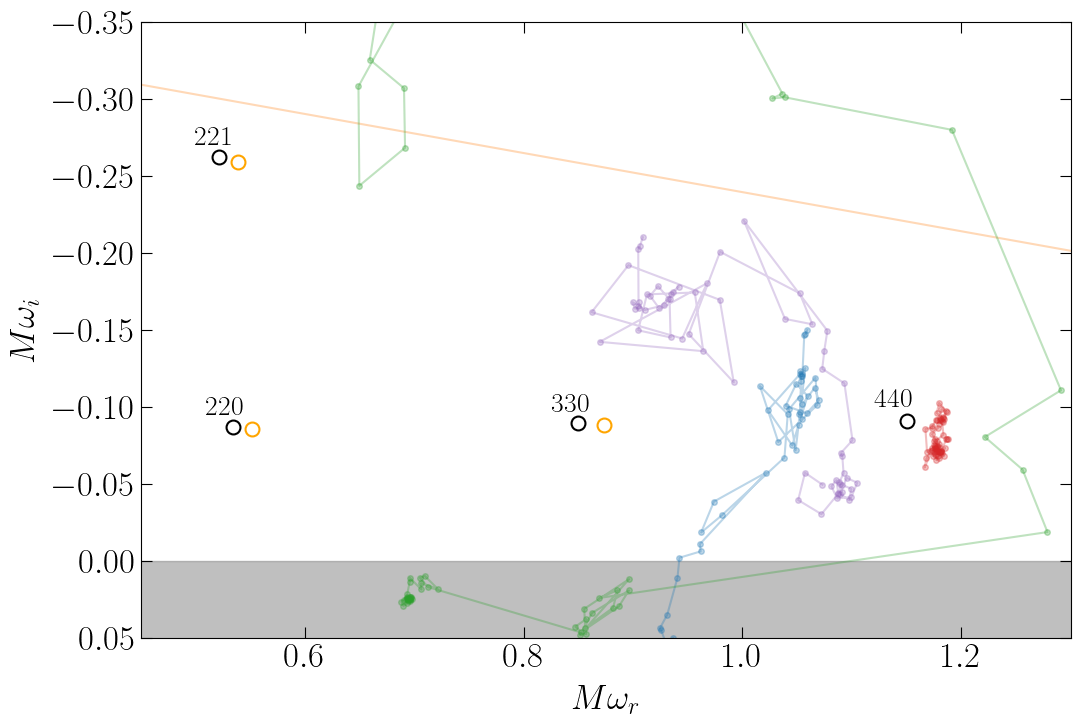

In [17]:
N_free=5
fig, ax = plt.subplots(figsize=(12,8))

# 绘制拟合结果
for k in range(N_free):
    omega_r_fit=np.zeros(len(t0_arr))
    omega_i_fit=np.zeros(len(t0_arr))
    for i in range(len(t0_arr)):
        omega_r_fit[i]=params_fit[i][2*N_fix+4*k+2]
        omega_i_fit[i]=params_fit[i][2*N_fix+4*k+3]

    ax.plot(omega_r_fit,omega_i_fit,alpha=0.3,marker="o",markersize=4)

# omega_list=["c,2,2,0","c,2,2,1","c,2,2,2", # natural linear modes
#             "c,3,2,0","c,4,2,0","c,5,2,0","c,6,2,0","c,7,2,0","c,8,2,0", # mixing modes
#             "constant", # constant mode
#             "r,2,2,0", # retrograde modes
#             ] 

omega_list=["c,2,2,0","r,2,2,0","c,2,2,1","c,3,3,0","c,4,4,0","c,5,5,0"]

def to_latex_format(s):
    return rf'$\rm {s}$'

texts=[]
for i in range(len(omega_list)):
    first_part=omega_list[i].split(',')[0]
    if first_part == "constant":
        omega_x=0
        omega_y=0
    elif first_part == "c":
        parts=omega_list[i].split(',')[1:]
        l,m,n=map(int,parts)
        omega_i=qnm.modes_cache(s=-2,l=l,m=m,n=n)(a=a_f)[0]
        omega_x=omega_i.real*M/M_f
        omega_y=omega_i.imag*M/M_f
    elif first_part == "r":
        parts=omega_list[i].split(',')[1:]
        l,m,n=map(int,parts)
        omega_i=qnm.modes_cache(s=-2,l=l,m=-m,n=n)(a=a_f)[0]
        omega_x=-omega_i.real*M/M_f
        omega_y=omega_i.imag*M/M_f
    else:
        omega_x=-100
        omega_y=-100
        print("invalid mode name")
    ax.plot(omega_x,omega_y,marker='o',markeredgecolor='black',\
    markerfacecolor='none',markersize=10,markeredgewidth=1.5)
#     texts.append(ax.annotate(to_latex_format(omega_list[i]),[omega_x,omega_y],\
#     ha='center',fontsize=20))



num=0
den=0
for k in range(4):
    for j in range(4):
        num+=My_Fitting.bkj_220r[k][j]*a_f**k*q_f**j
        den+=My_Fitting.ckj_220r[k][j]*a_f**k*q_f**j

omega_KN_220_r=(qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=0)[0].real*num/den)/M_f*M

num=0
den=0
for k in range(4):
    for j in range(4):
        num+=My_Fitting.bkj_220i[k][j]*a_f**k*q_f**j
        den+=My_Fitting.ckj_220i[k][j]*a_f**k*q_f**j

omega_KN_220_i=(qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=0)[0].imag*num/den)/M_f*M

ax.plot(omega_KN_220_r,omega_KN_220_i,marker='o',markeredgecolor='orange',\
    markerfacecolor='none',markersize=10,markeredgewidth=1.5)

num=0
den=0
for k in range(4):
    for j in range(4):
        num+=My_Fitting.bkj_221r[k][j]*a_f**k*q_f**j
        den+=My_Fitting.ckj_221r[k][j]*a_f**k*q_f**j

omega_KN_221_r=(qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=0)[0].real*num/den)/M_f*M

num=0
den=0
for k in range(4):
    for j in range(4):
        num+=My_Fitting.bkj_221i[k][j]*a_f**k*q_f**j
        den+=My_Fitting.ckj_221i[k][j]*a_f**k*q_f**j

omega_KN_221_i=(qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=0)[0].imag*num/den)/M_f*M

ax.plot(omega_KN_221_r,omega_KN_221_i,marker='o',markeredgecolor='orange',\
    markerfacecolor='none',markersize=10,markeredgewidth=1.5)



num=0
den=0
for k in range(4):
    for j in range(4):
        num+=My_Fitting.bkj_330r[k][j]*a_f**k*q_f**j
        den+=My_Fitting.ckj_330r[k][j]*a_f**k*q_f**j

omega_KN_330_r=(qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=0)[0].real*num/den)/M_f*M

num=0
den=0
for k in range(4):
    for j in range(4):
        num+=My_Fitting.bkj_330i[k][j]*a_f**k*q_f**j
        den+=My_Fitting.ckj_330i[k][j]*a_f**k*q_f**j

omega_KN_330_i=(qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=0)[0].imag*num/den)/M_f*M

ax.plot(omega_KN_330_r,omega_KN_330_i,marker='o',markeredgecolor='orange',\
    markerfacecolor='none',markersize=10,markeredgewidth=1.5)




# adjust_text(texts,expand_text=(1.4, 2), expand_points=(1.0, 1.2))
ax.text(0.51,-0.095,r"$220$",fontsize=20)
ax.text(0.5,-0.27,r"$221$",fontsize=20)
# ax.text(0.7,-0.1,r"$320$",fontsize=20)
ax.text(0.825,-0.097,r"$330$",fontsize=20)
ax.text(1.12,-0.1,r"$440$",fontsize=20)
# ax.text(-0.4,-0.105,r"$r220$",fontsize=20)
# ax.text(1.4,-0.1,r"$550$",fontsize=20)

ax.set_xlim([0.45,1.3])
ax.set_ylim([-0.35,0.05])
ax.invert_yaxis()

# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax.plot([0,0],[-1,1],'--',color="gray")

x = np.array([-1, 2])
y1 = np.array([1, 1])
ax.fill_between(x, y1, color="gray", alpha=0.5)


plt.xlabel(r"$M\omega_{r}$",fontsize=25)
plt.ylabel(r"$M\omega_{i}$",fontsize=25)
plt.savefig("/mnt/c/Users/91228/Documents/VScode_code/KerrNewmanFigure/440_omega.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)